# Cell area analysis

This notebook analyses all the areas of the detected cells and gets average cell size for the datasets

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
from typing import Optional
import matplotlib.pyplot as plt

### Definitions

In [2]:
sys.path.insert(0, "../../")
from config import DATASETS_PATH

# Dataset selection
DATASET = 'ina'
DATASET_SECTION = ''

# Paths
CSV_PATH = os.path.join(DATASETS_PATH, 'cropped', DATASET, 'data', DATASET_SECTION)

OUTPUT_CSV_PATH = os.path.join(DATASETS_PATH, 'cropped', 'ina_sam_mask_areas.csv')

OUTPUT_JSON_PATH = os.path.join(DATASETS_PATH, 'cropped', 'datasets_area_data.json')

data = []

In [3]:
CSV_PATH



'/home/rawthil/Documents/GIAR/INA/INA_code/giar_ina_dev/datasets/cropped/ina/data/'

In [4]:
import glob

all_files = glob.glob(os.path.join(CSV_PATH, "*.csv"))
dfs = []

for file in all_files:
    df = pd.read_csv(file)
    
    # Extract image_section and image_id from filename (e.g., "001_0001.csv")
    filename = os.path.splitext(os.path.basename(file))[0]
    sample, image_id = filename.split("_")

    df["image_id"] = image_id
    df["sample"] = sample

    # Keep only the required columns
    df = df[["image_id", "cell_id", "bbox_area", "sample"]]
    dfs.append(df)

# Combine all into a single DataFrame
df = pd.concat(dfs, ignore_index=True)


In [5]:
df.columns

Index(['image_id', 'cell_id', 'bbox_area', 'sample'], dtype='object')

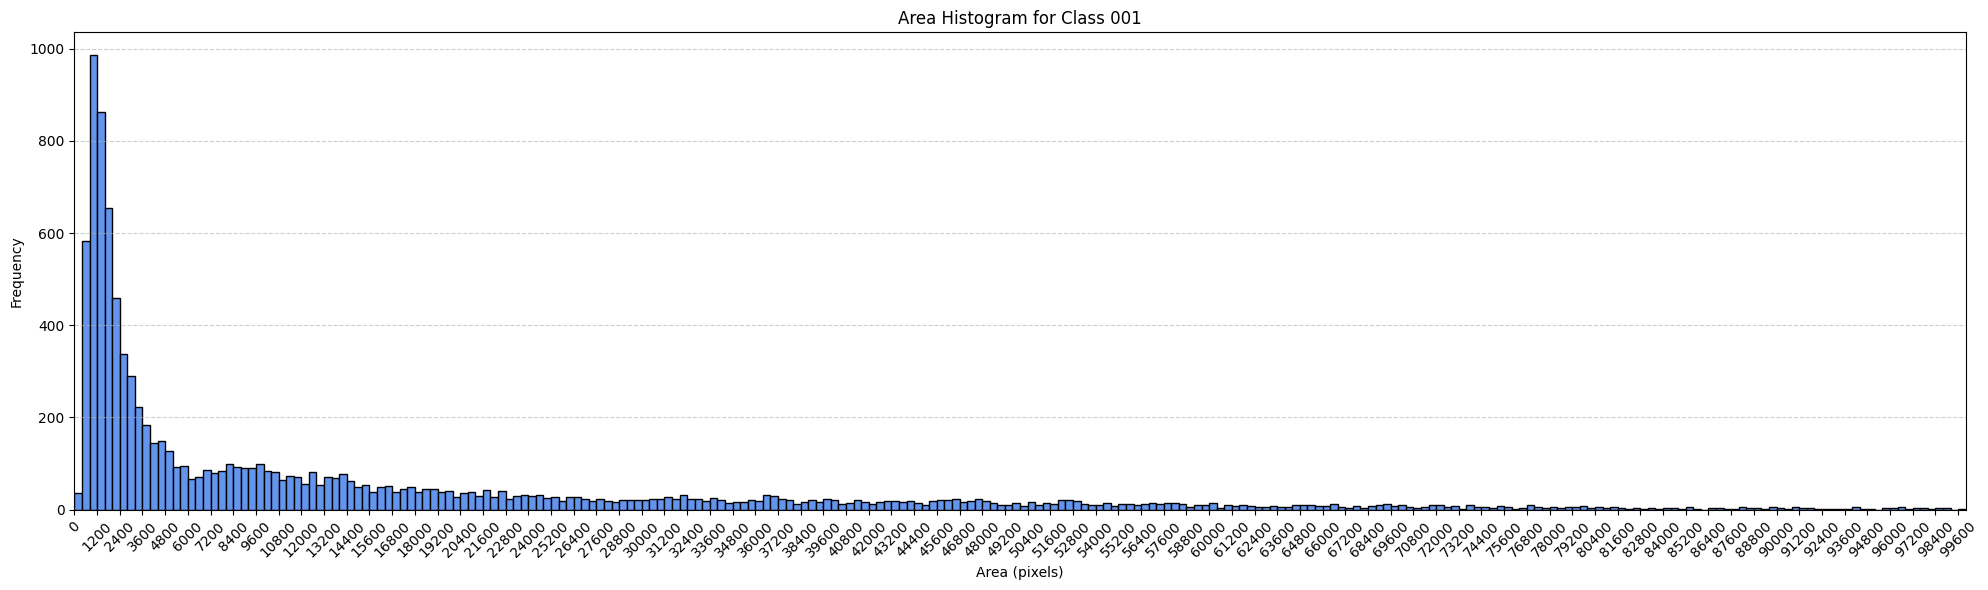

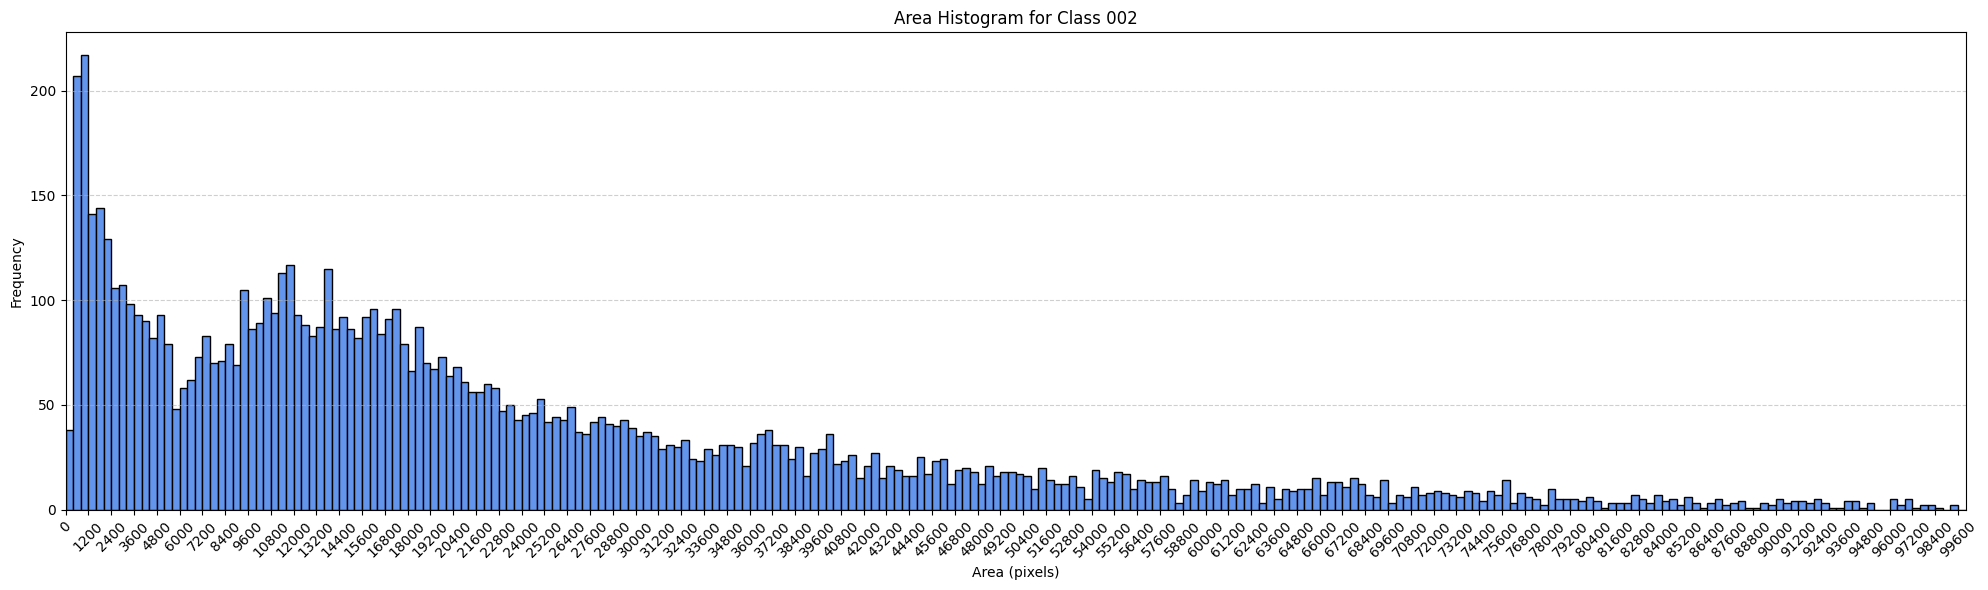

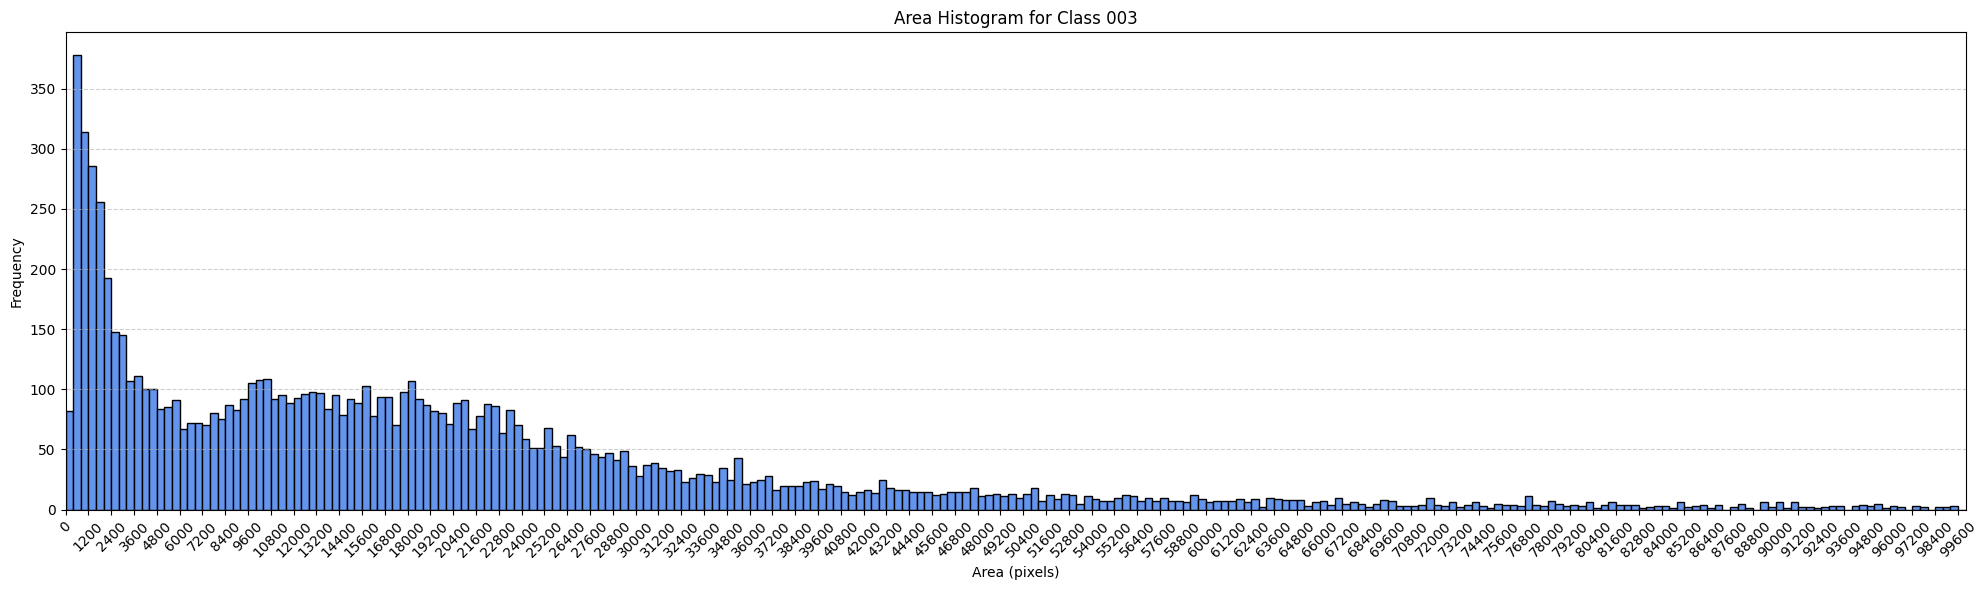

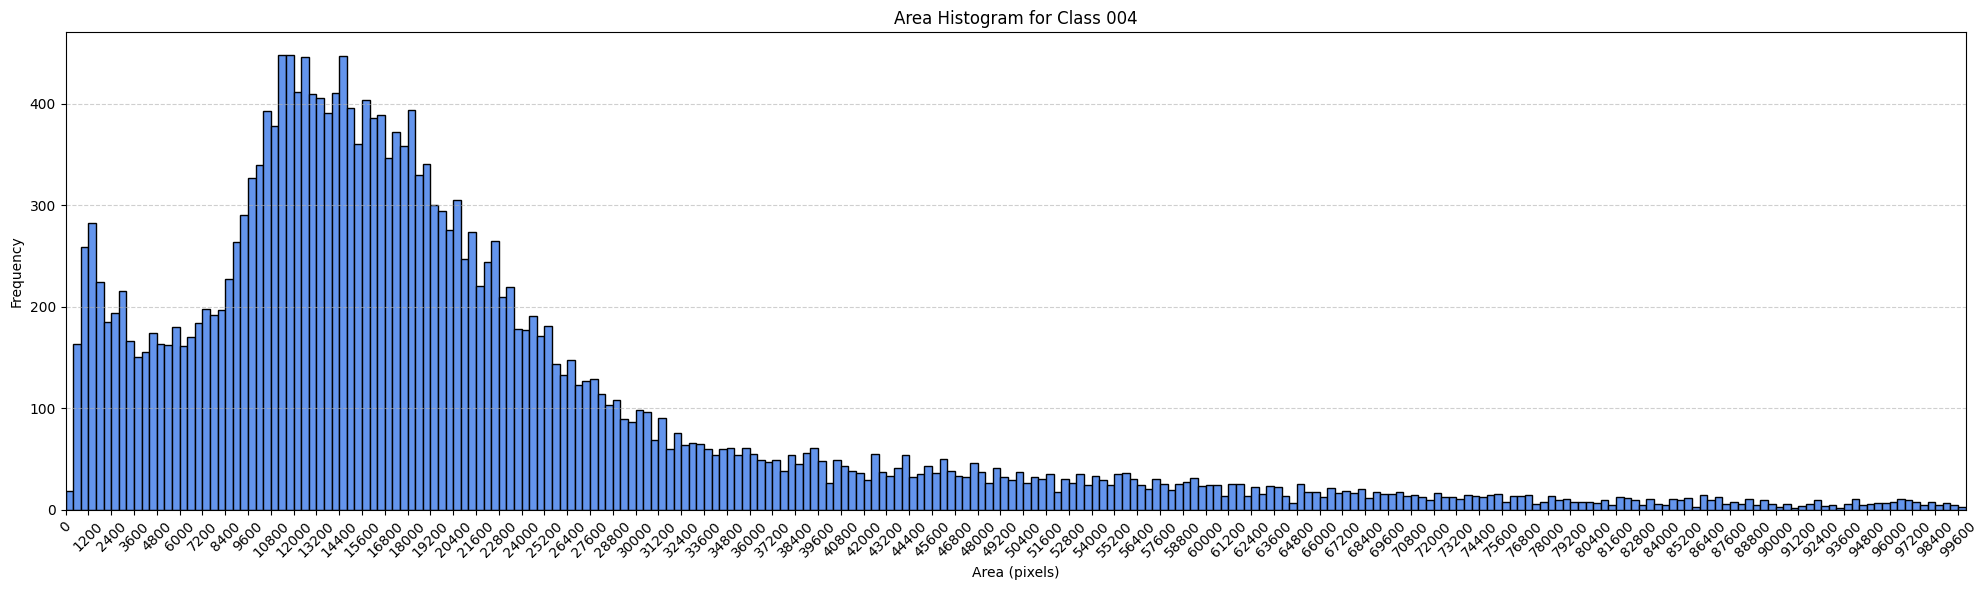

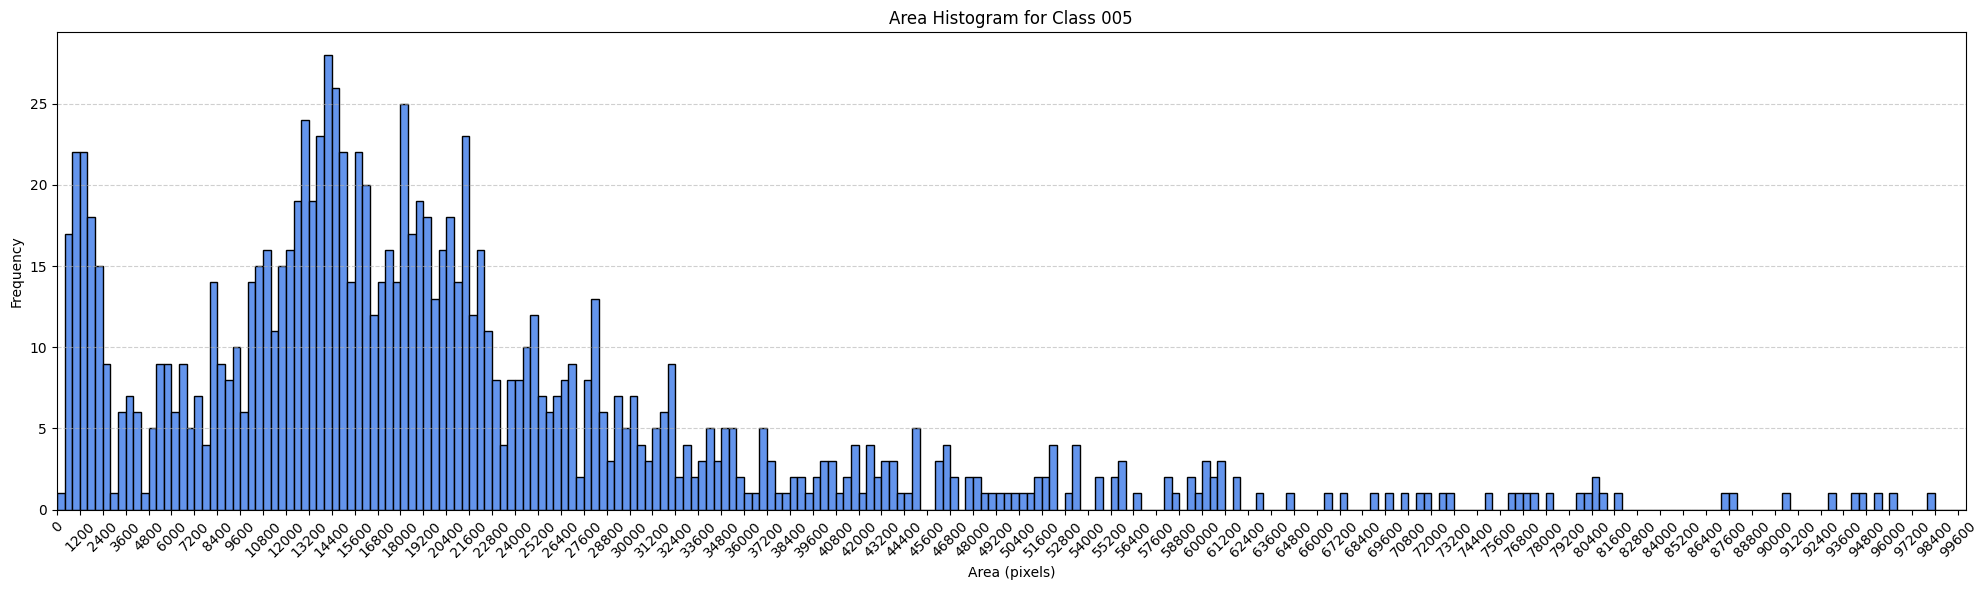

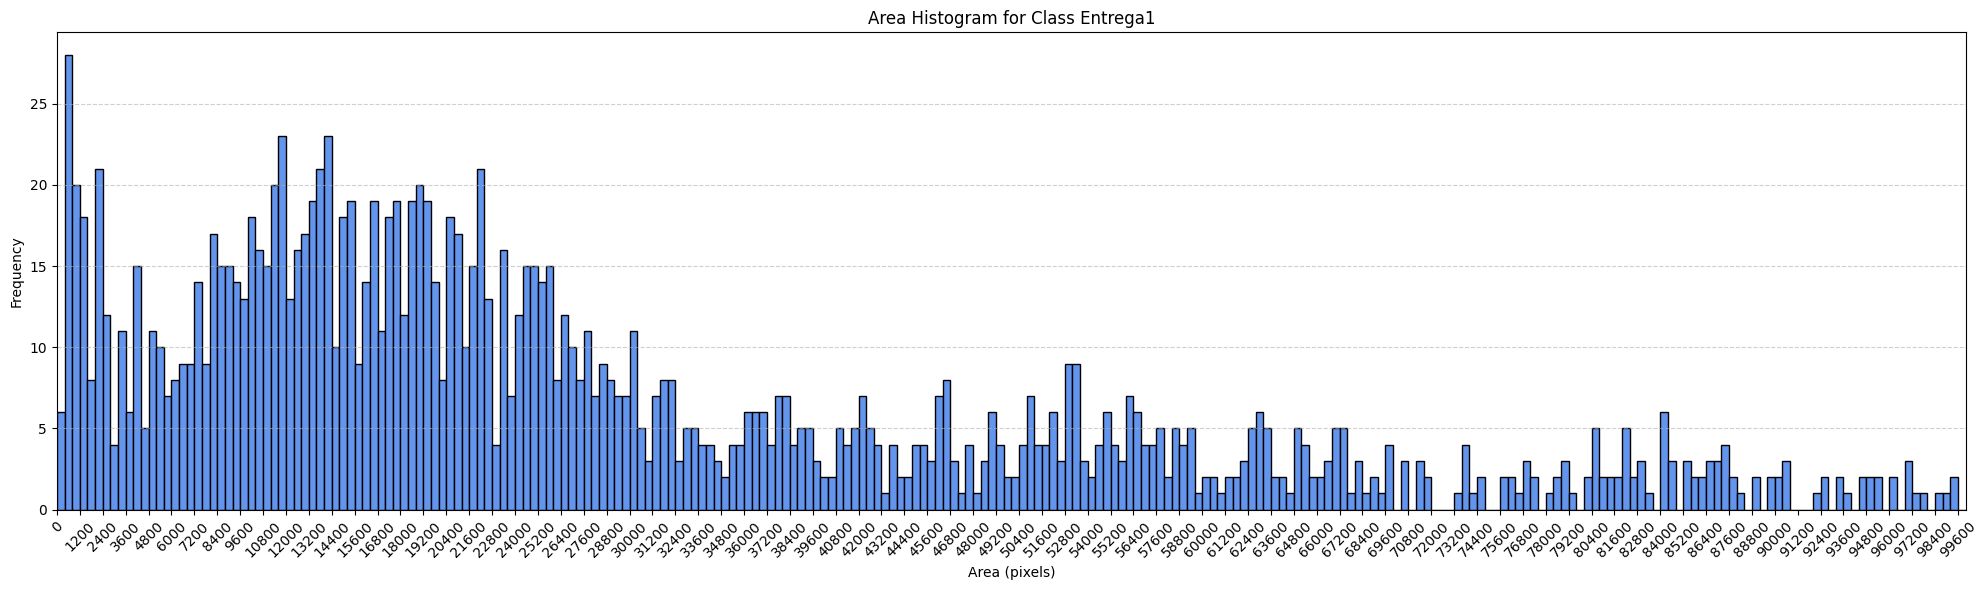

In [6]:
# Set fixed bins and xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 3, bin_width * 3)

# Get unique samples
samples = sorted(df['sample'].unique())

# Plot histograms for each class
for cls in samples:
    class_df = df[df['sample'] == cls]
    
    plt.figure(figsize=(20, 6))
    plt.hist(class_df['bbox_area'], bins=bins, color='cornflowerblue', edgecolor='black')
    plt.title(f"Area Histogram for Class {cls}")
    plt.xlabel("Area (pixels)")
    plt.ylabel("Frequency")
    plt.xticks(xticks, rotation=45)
    plt.xlim(bin_start, bin_end)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


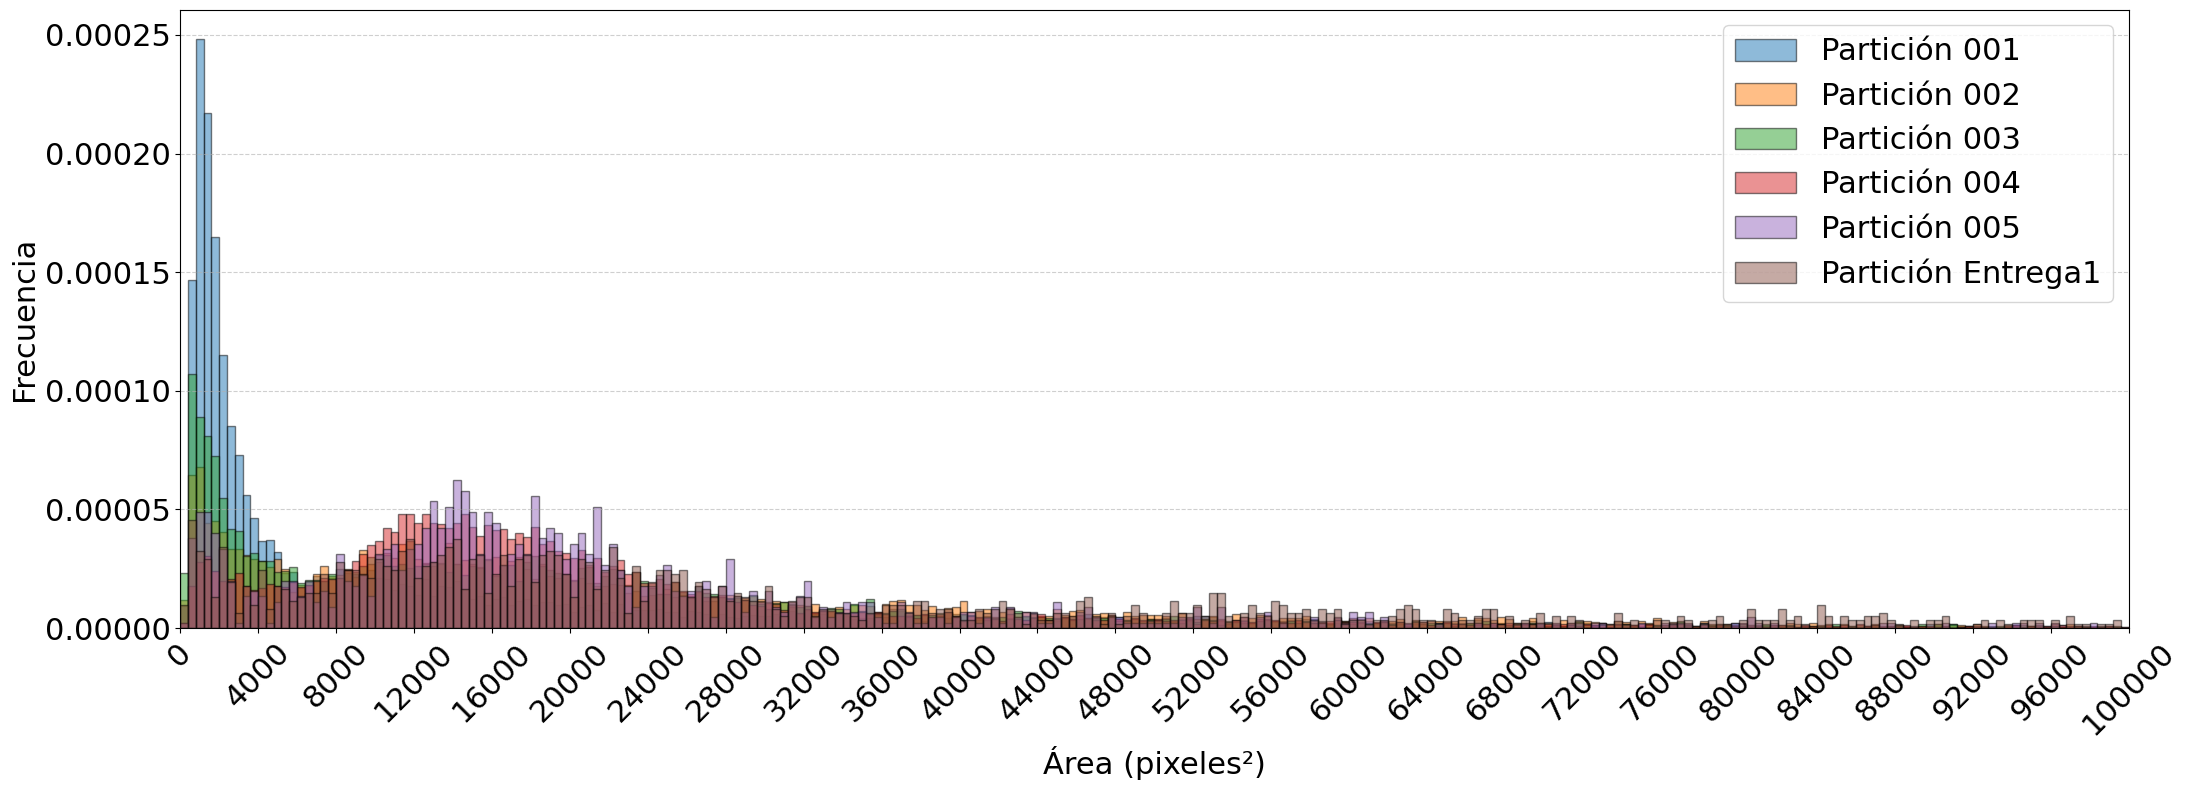

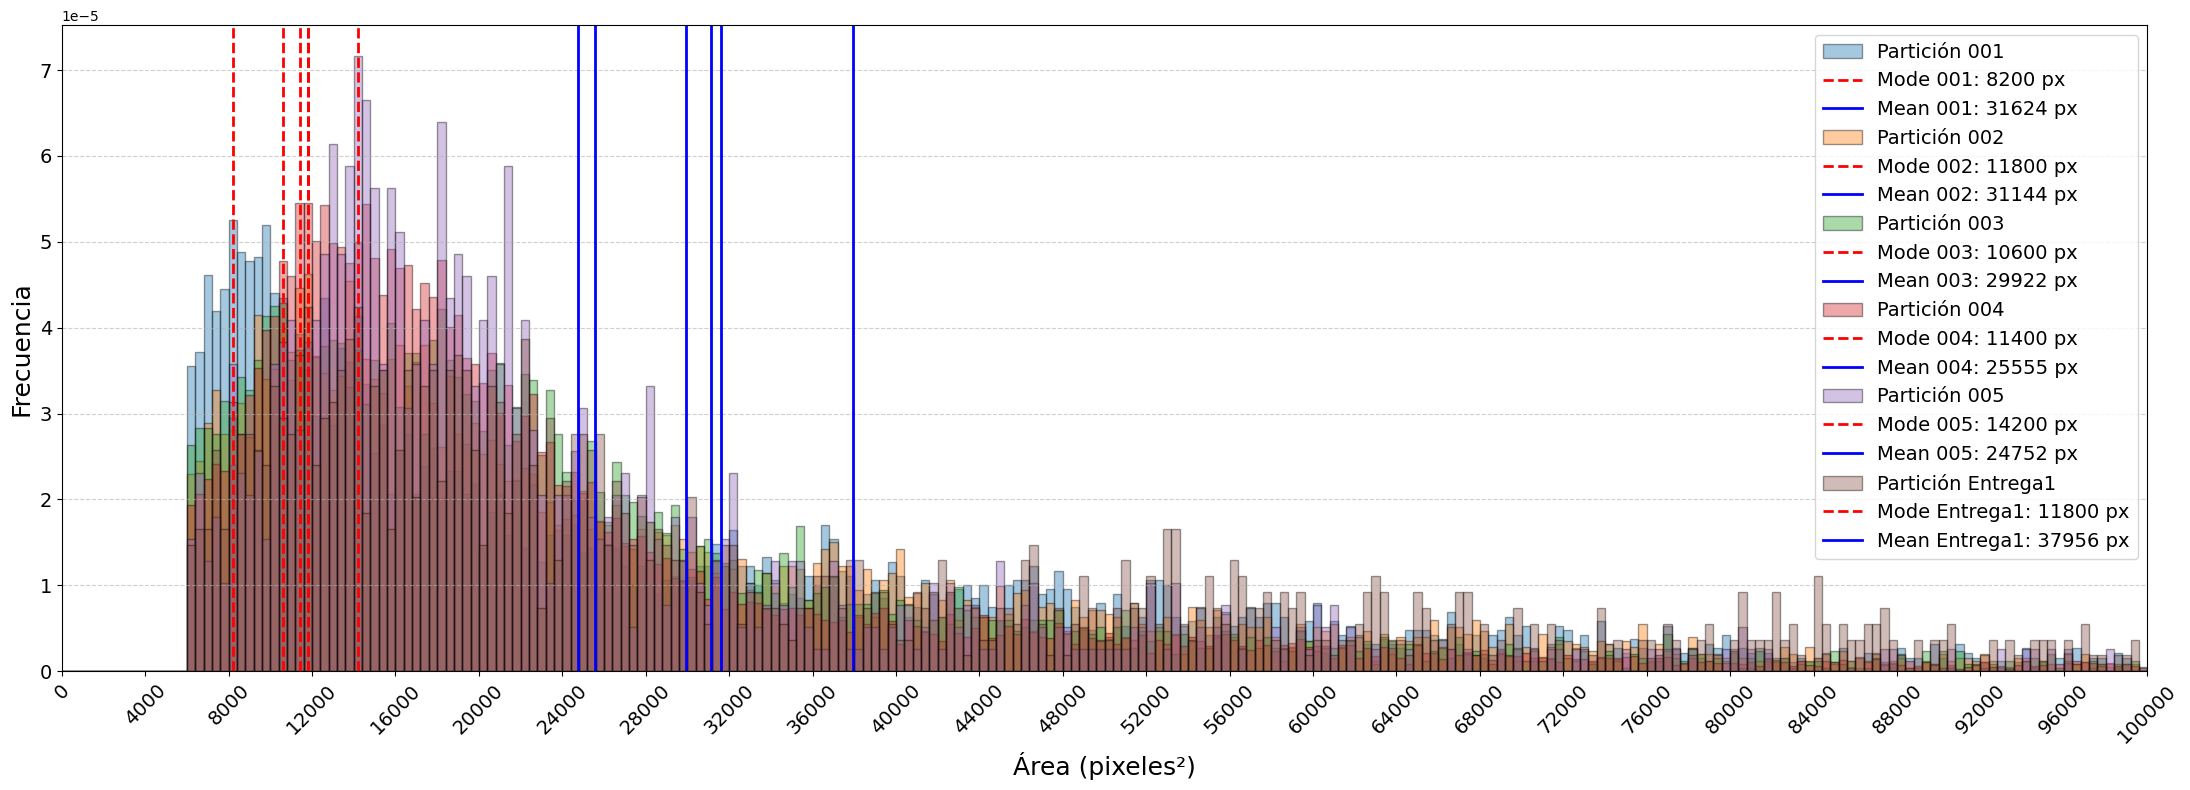

In [7]:
# Filtered data
df_filtered = df[df['bbox_area'] > 6000]

# Bins y xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 10, bin_width * 10)  # menos ticks

# Clases
classes = sorted(df['sample'].unique())

# -------------------------------
# Plot 1: Normalized histograms (All Data)
plt.figure(figsize=(22, 8))
for cls in classes:
    class_df = df[df['sample'] == cls]
    plt.hist(class_df['bbox_area'], bins=bins, alpha=0.5, label=f'Partición {cls}',
             edgecolor='black', density=True)

plt.xlabel("Área (pixeles²)", fontsize=22)
plt.ylabel("Frecuencia", fontsize=22)
plt.xticks(xticks, rotation=45, fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(bin_start, bin_end)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=22, loc='upper right')
plt.tight_layout()
plt.savefig('my_plot.jpg', dpi=800, format='jpg')
plt.show()

# -------------------------------
# Plot 2: Normalized histograms (Filtered data > 6000) con moda y media
plt.figure(figsize=(22, 8))

for cls in classes:
    class_df = df_filtered[df_filtered['sample'] == cls]
    if len(class_df) < 5:
        continue

    # Histograma
    plt.hist(class_df['bbox_area'], bins=bins, alpha=0.4, label=f'Partición {cls}',
             edgecolor='black', density=True)
    
    # Moda
    counts, edges = np.histogram(class_df['bbox_area'], bins=bins, density=True)
    max_bin_idx = np.argmax(counts)
    mode_center = (edges[max_bin_idx] + edges[max_bin_idx + 1]) / 2
    plt.axvline(x=mode_center, linestyle='--', color='red', linewidth=2,
                label=f'Mode {cls}: {int(mode_center)} px')
    
    # Media
    mean_val = class_df['bbox_area'].mean()
    plt.axvline(x=mean_val, linestyle='-', color='blue', linewidth=2,
                label=f'Mean {cls}: {int(mean_val)} px')

plt.xlabel("Área (pixeles²)", fontsize=18)
plt.ylabel("Frecuencia", fontsize=18)
plt.xticks(xticks, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(bin_start, bin_end)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.show()


In [8]:
from dataclasses import dataclass, asdict

@dataclass
class AreaData:
    area_promedio: int
    lado_cuadrado: float
    diff_area: Optional[float] = None
    dif_lado: Optional[float] = None

    

partitions_data = {}

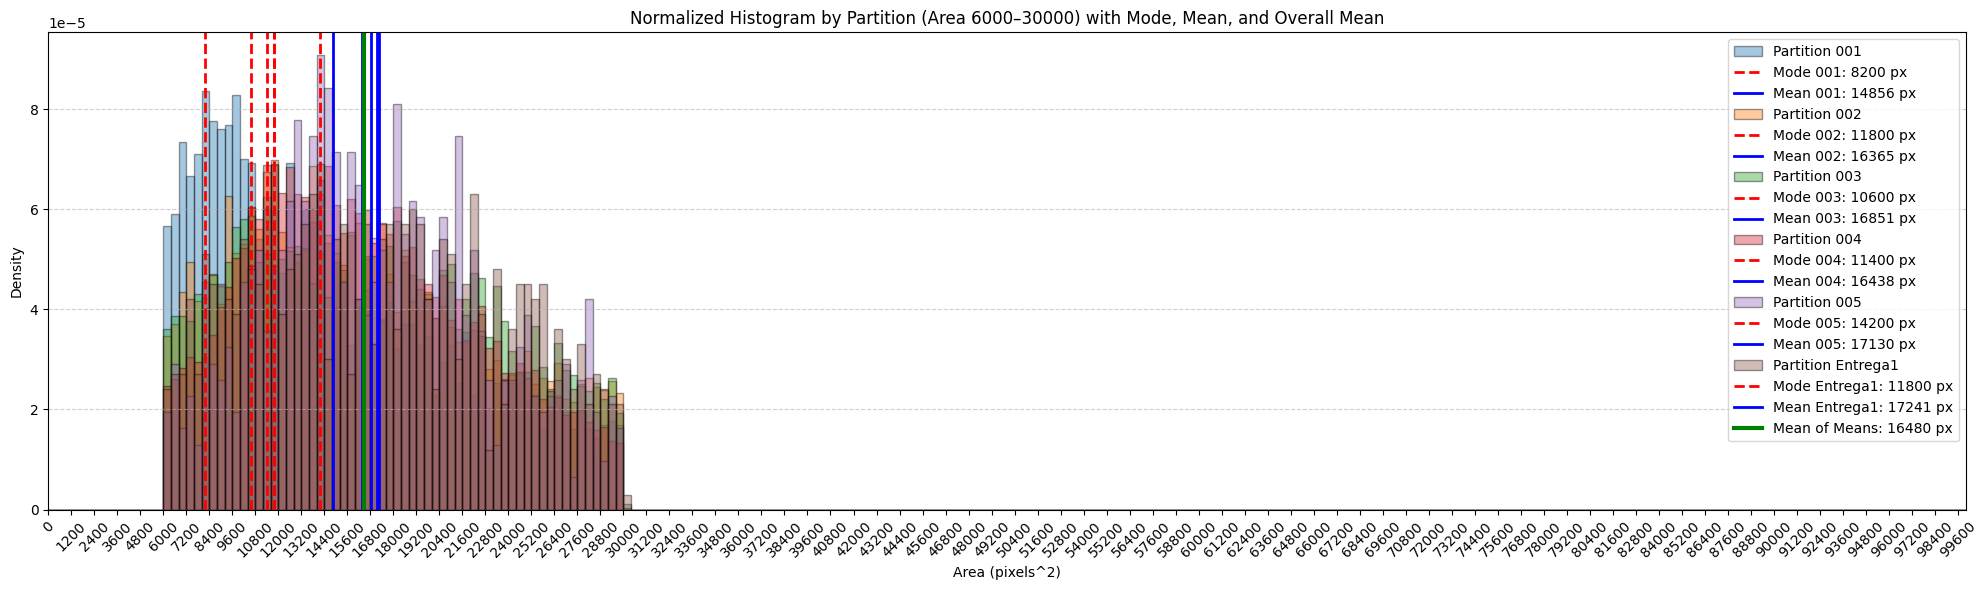

In [9]:
# Filtered data
df_filtered = df[(df['bbox_area'] >= 6000) & (df['bbox_area'] <= 30000)]

# Set fixed bins and xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 3, bin_width * 3)

# Track means
class_means = []

# Plot: Normalized histograms (filtered data)
plt.figure(figsize=(20, 6))

for cls in classes:
    class_df = df_filtered[df_filtered['sample'] == cls]
    if len(class_df) < 5:
        continue

    # Plot histogram
    plt.hist(class_df['bbox_area'], bins=bins, alpha=0.4, label=f'Partition {cls}',
             edgecolor='black', density=True)

    # Mode (most frequent bin center)
    counts, edges = np.histogram(class_df['bbox_area'], bins=bins, density=True)
    max_bin_idx = np.argmax(counts)
    mode_center = (edges[max_bin_idx] + edges[max_bin_idx + 1]) / 2
    plt.axvline(x=mode_center, linestyle='--', color='red', linewidth=2,
                label=f'Mode {cls}: {int(mode_center)} px')

    # Mean
    mean_val = class_df['bbox_area'].mean()
    class_means.append(mean_val)
    plt.axvline(x=mean_val, linestyle='-', color='blue', linewidth=2,
                label=f'Mean {cls}: {int(mean_val)} px')

# Mean of class means
if class_means:
    mean_of_means = np.mean(class_means)
    plt.axvline(x=mean_of_means, linestyle='-', color='green', linewidth=3,
                label=f'Mean of Means: {int(mean_of_means)} px')

plt.title("Normalized Histogram by Partition (Area 6000–30000) with Mode, Mean, and Overall Mean")
plt.xlabel("Area (pixels^2)")
plt.ylabel("Density")
plt.xticks(xticks, rotation=45)
plt.xlim(bin_start, bin_end)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()




In [10]:

partitions_data['ina_sam'] = dict()
partitions_data['ina_sam']['Abril2023'] = asdict(AreaData(
                                        area_promedio = mean_of_means,
                                        lado_cuadrado = np.sqrt(mean_of_means),
                                        diff_area = None,
                                        dif_lado = None))
partitions_data

{'ina_sam': {'Abril2023': {'area_promedio': np.float64(16480.678915271677),
   'lado_cuadrado': np.float64(128.37709653700568),
   'diff_area': None,
   'dif_lado': None}}}

In [11]:
DATASET = 'onion_cell_merged'
DATASET_SECTION = 'test'

# Paths
CSV_PATH = os.path.join(DATASETS_PATH, 'cropped', DATASET, 'data', DATASET_SECTION)
CSV_PATH

'/home/rawthil/Documents/GIAR/INA/INA_code/giar_ina_dev/datasets/cropped/onion_cell_merged/data/test'

In [12]:
all_files = glob.glob(os.path.join(CSV_PATH, "*.csv"))
dfs = []

for file in all_files:
    df_r = pd.read_csv(file)
    
    # Extract image_section and image_id from filename (e.g., "001_0001.csv")
    filename = os.path.splitext(os.path.basename(file))[0]
    sample, image_id = filename.split("_")

    df_r["image_id"] = image_id
    df_r["sample"] = sample

    # Keep only the required columns
    df_r = df_r[["image_id", "cell_id", "bbox_area", "sample"]]
    dfs.append(df_r)

# Combine all into a single DataFrame
df_r = pd.concat(dfs, ignore_index=True)

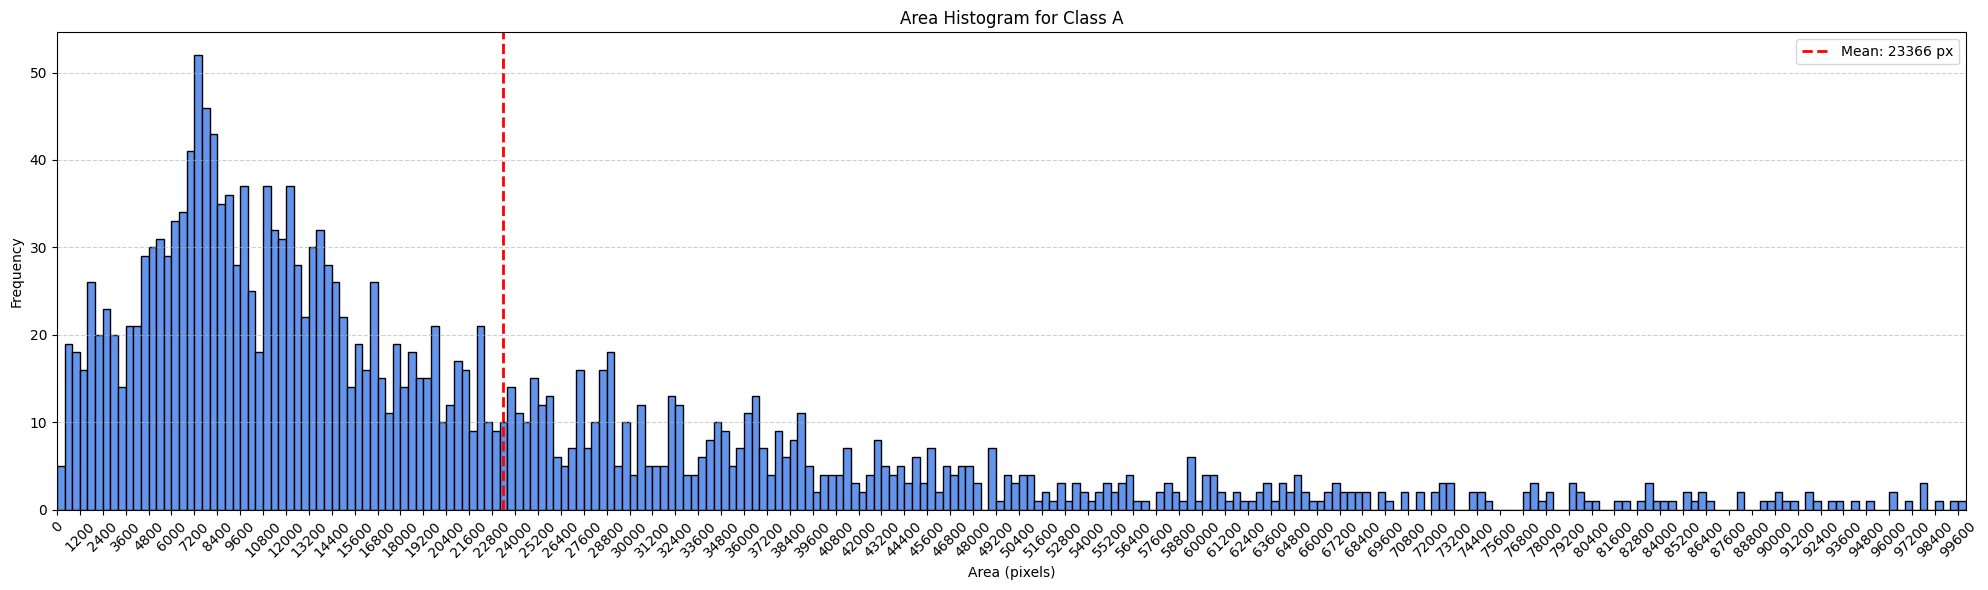

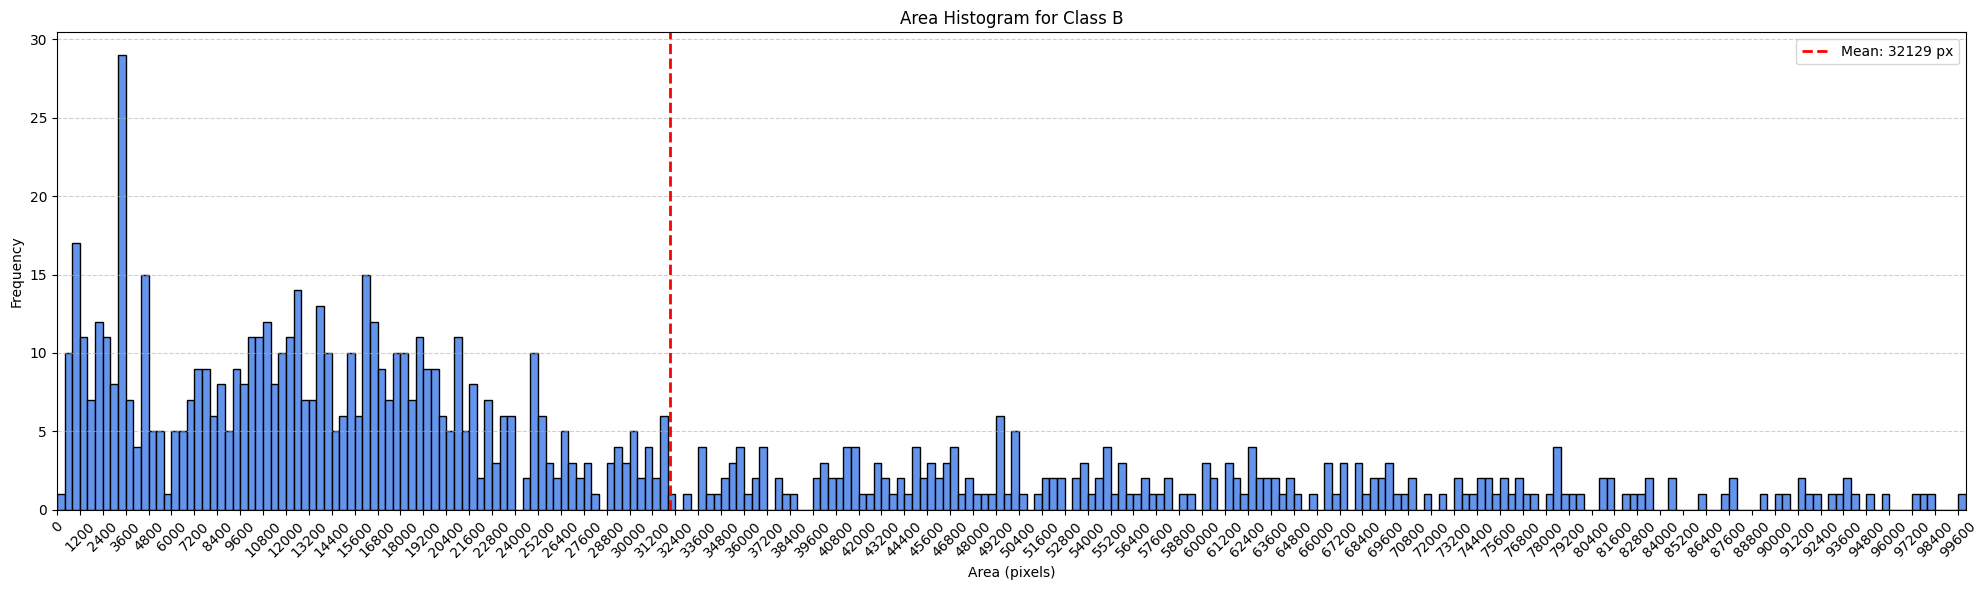

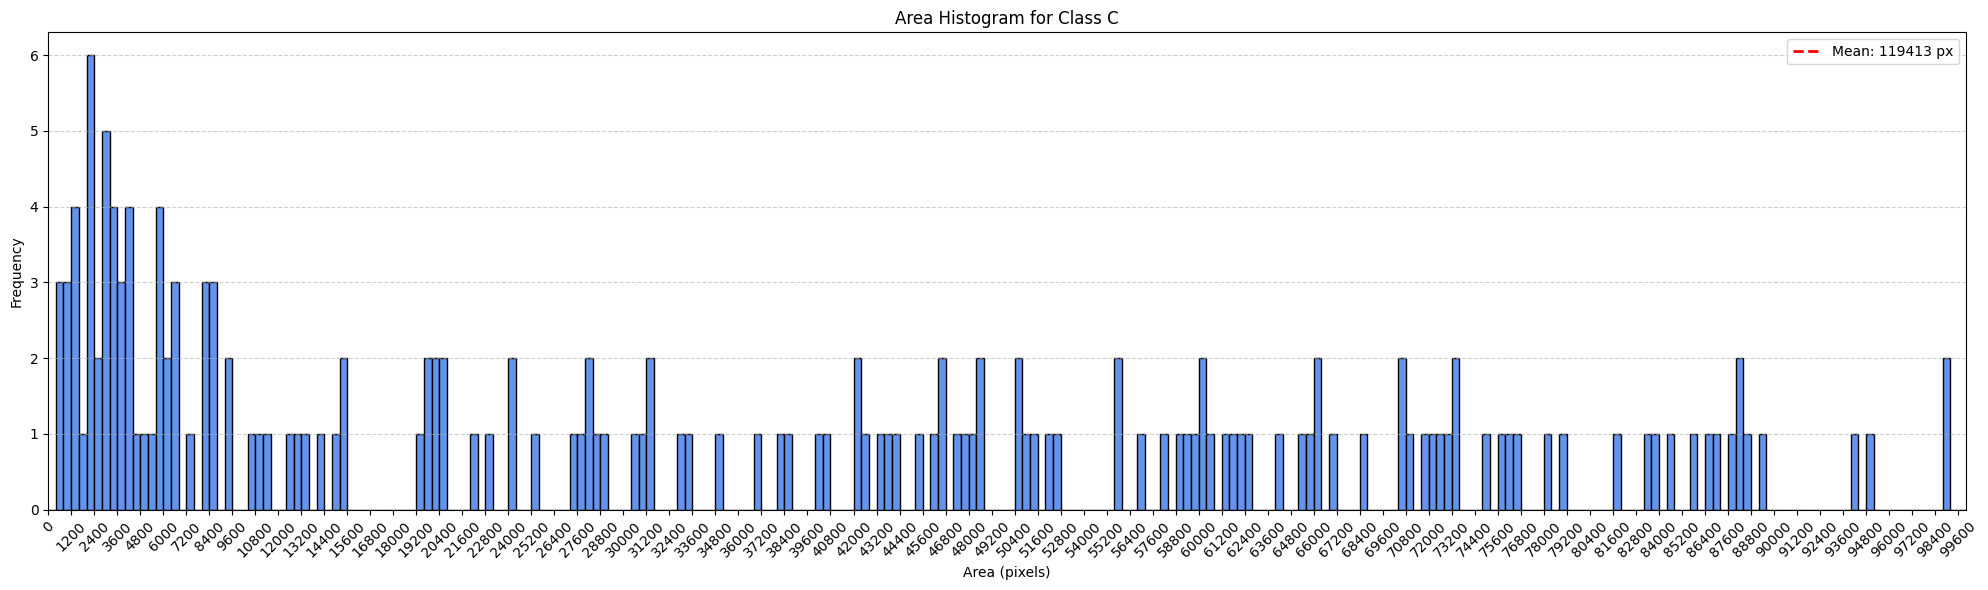

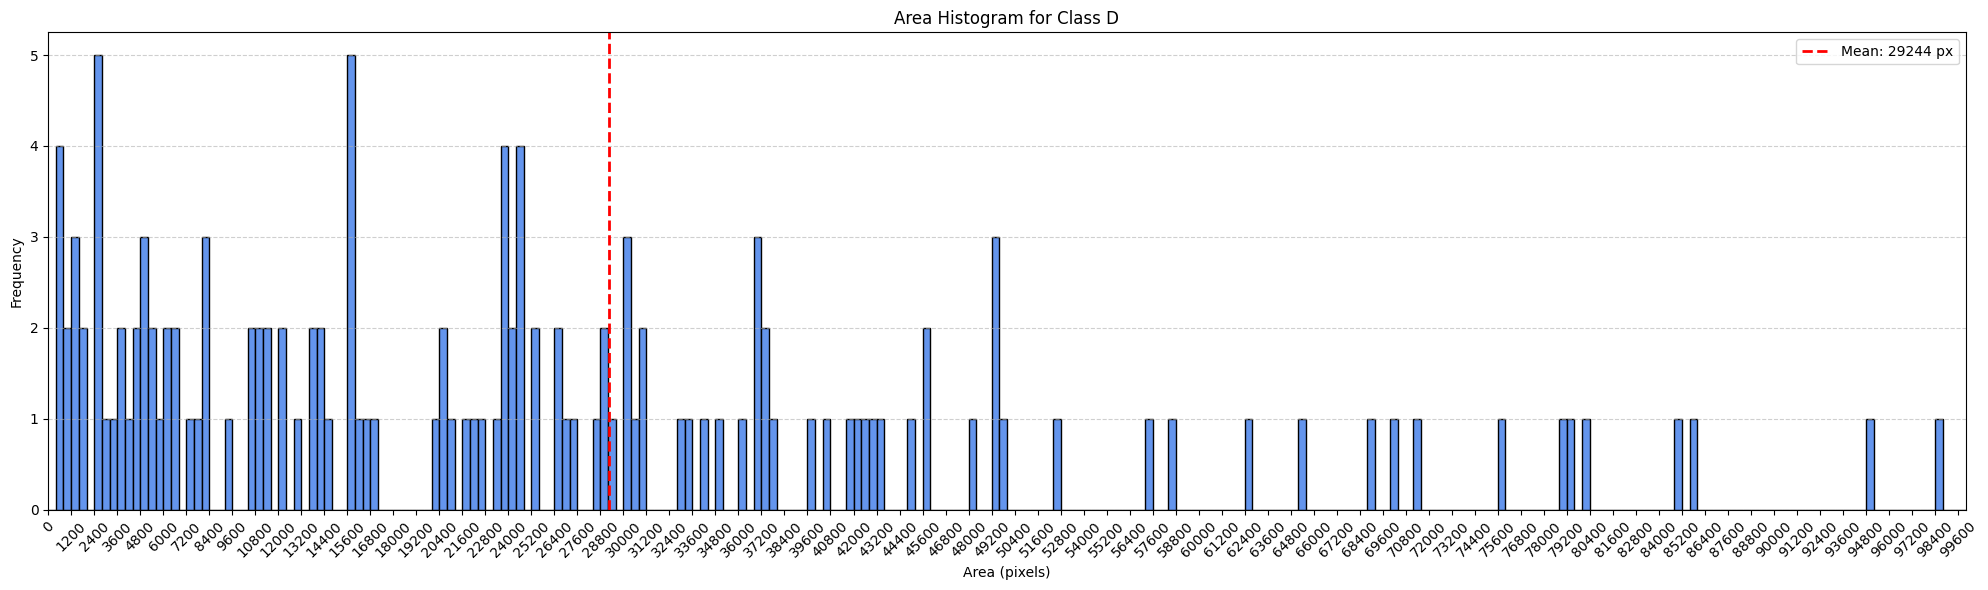

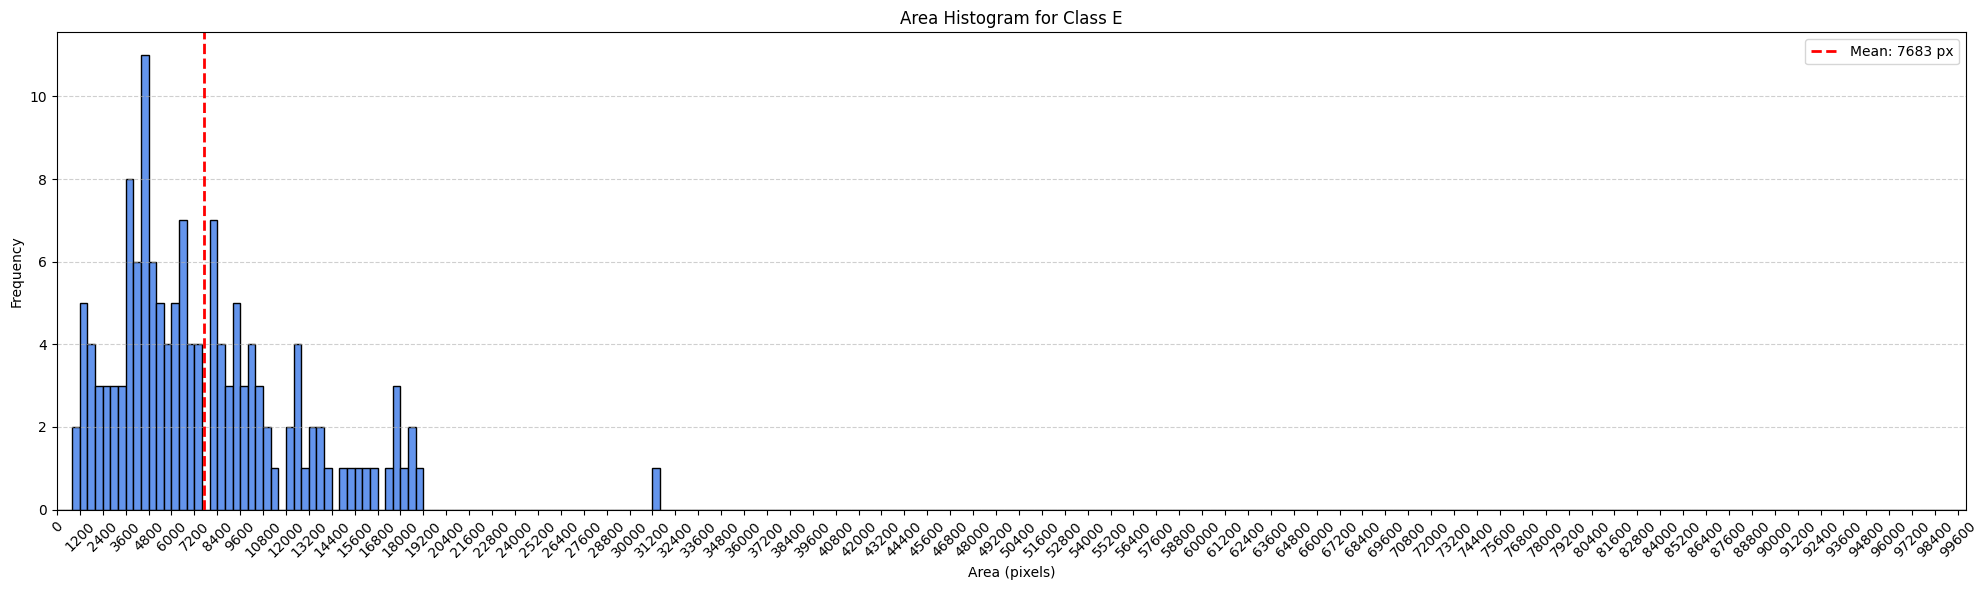

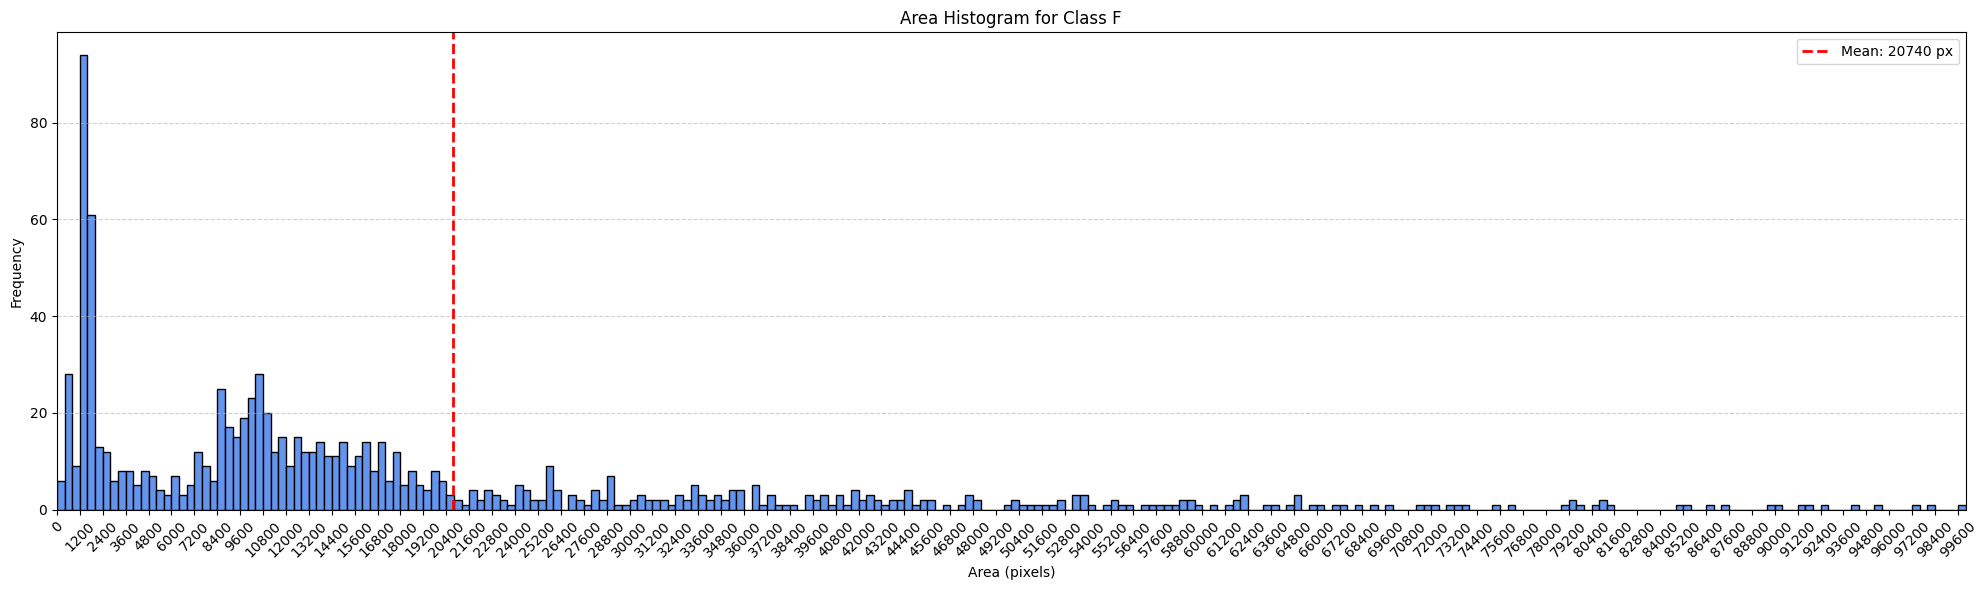

In [13]:

# Set fixed bins and xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 3, bin_width * 3)

partitions_data['onion_cell_merged'] = {}


# Get unique classes
classes = sorted(df_r['sample'].unique())

# Plot histograms for each class
for cls in classes:
    class_df_r = df_r[df_r['sample'] == cls]
    
    plt.figure(figsize=(20, 6))
    plt.hist(class_df_r['bbox_area'], bins=bins, color='cornflowerblue', edgecolor='black')
    
    # Compute and plot mean
    mean_val = class_df_r['bbox_area'].mean()


    partitions_data['onion_cell_merged'][cls] = asdict(AreaData(area_promedio = mean_val,
                                                            lado_cuadrado = np.sqrt(mean_val),
                                                            diff_area = partitions_data['ina_sam']['Abril2023']["area_promedio"] -  mean_val,
                                                            dif_lado = partitions_data['ina_sam']['Abril2023']["lado_cuadrado"] -  np.sqrt(mean_val)))

    plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean: {int(mean_val)} px")
    
    plt.title(f"Area Histogram for Class {cls}")
    plt.xlabel("Area (pixels)")
    plt.ylabel("Frequency")
    plt.xticks(xticks, rotation=45)
    plt.xlim(bin_start, bin_end)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
partitions_data

{'ina_sam': {'Abril2023': {'area_promedio': np.float64(16480.678915271677),
   'lado_cuadrado': np.float64(128.37709653700568),
   'diff_area': None,
   'dif_lado': None}},
 'onion_cell_merged': {'A': {'area_promedio': np.float64(23366.150216658643),
   'lado_cuadrado': np.float64(152.85990388803285),
   'diff_area': np.float64(-6885.471301386966),
   'dif_lado': np.float64(-24.482807351027162)},
  'B': {'area_promedio': np.float64(32129.23943661972),
   'lado_cuadrado': np.float64(179.24630940864506),
   'diff_area': np.float64(-15648.560521348041),
   'dif_lado': np.float64(-50.86921287163938)},
  'C': {'area_promedio': np.float64(119413.89156626505),
   'lado_cuadrado': np.float64(345.5631513432314),
   'diff_area': np.float64(-102933.21265099337),
   'dif_lado': np.float64(-217.18605480622574)},
  'D': {'area_promedio': np.float64(29244.113475177306),
   'lado_cuadrado': np.float64(171.00910348626854),
   'diff_area': np.float64(-12763.434559905629),
   'dif_lado': np.float64(-42.6

In [15]:
# Ensure folder exists
# os.makedirs(os.path.dirname(TEMP_PATH), exist_ok=True)

# Write JSON, converting np.float64 to float inline
with open(OUTPUT_JSON_PATH, "w") as f:
    json.dump(partitions_data, f, default=lambda x: x.item() if isinstance(x, np.generic) else x, indent=2)

In [16]:
OUTPUT_JSON_PATH

'/home/rawthil/Documents/GIAR/INA/INA_code/giar_ina_dev/datasets/cropped/datasets_area_data.json'